## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier. Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles. Estimate a bounding box for vehicles detected.

### 0. Load Libraries

In [174]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label

import numpy as np
import pandas as pd
import cv2
import glob
import time
import scipy.misc

from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### 0.Bis. Generate more car data from Udacity's labeled dataset (finally not used)

In [166]:
labels_csv = pd.read_csv('train_data/vehicles/labels.csv', sep=',')
labels_csv['number'] = labels_csv.index
labels_csv.head(5)

xmin  xmax  ymin  ymax                    Frame  Label  \
0   785   533   905   644  1479498371963069978.jpg    Car   
1    89   551   291   680  1479498371963069978.jpg    Car   
2   268   546   383   650  1479498371963069978.jpg    Car   
3   455   522   548   615  1479498371963069978.jpg  Truck   
4   548   522   625   605  1479498371963069978.jpg  Truck   

                                         Preview URL  number  
0  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...       0  
1  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...       1  
2  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...       2  
3  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...       3  
4  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...       4

In [175]:
def get_vehicle_img(row):
    if row.Label == 'Car':
        file = 'train_data/vehicles/object_detection_crowdai/' + row.Frame
        img = mpimg.imread(file)
        target_img = img[row.xmax:row.ymax, row.xmin:row.ymin, :]
        target_img = cv2.resize(target_img, (64, 64))
        scipy.misc.toimage(target_img).save('train_data/vehicles/Crowdai/img_' + str(row.number) +'.png')
        return 1
    else:
        return 0
        
extracted = labels_csv.head(2000).apply(get_vehicle_img, axis=1)
print('Nb of car images extracted: ', len(extracted[extracted == 1]))

Nb of car images extracted:  1932


### 1. Feature Extraction & Classfier Training

#### Histogram of Oriented Gradients (HOG) feacture extraction

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

#### Color histogram feature extraction

In [3]:
# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 1)):
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

#### Spatial binned color feature extraction

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    
    # Return the feature vector
    return features

#### Convert color space

In [12]:
def convert_color(img, conv):
    if conv == 'RGB':
        return np.copy(img)
    elif conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    else:
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

#### Combined feacture extraction

In [13]:
# Define a function to extract features from a single image window 
# by combining HOG feature extraction, color histogram extraction and spatial binned color extraction 
def single_img_features(img, color_space='RGB', spatial_size=(32, 32), hist_bins=32, 
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    
    # Define an empty list to receive features
    img_features = []
    
    # Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, color_space)    
    
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    
    # Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], orient, 
                                                     pix_per_cell, cell_per_block, 
                                                     vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block, 
                                            vis=False, feature_vec=True)
        img_features.append(hog_features)

    # Return concatenated array of features
    return np.concatenate(img_features)

#### Read image data

Car training dataset size:  (7037, 64, 64, 3)
Car testing dataset size:  (1755, 64, 64, 3)
Not car training dataset size (7176, 64, 64, 3)
Not car testing dataset size (1792, 64, 64, 3)
Car image data type:  float32
Non car image data type:  float32


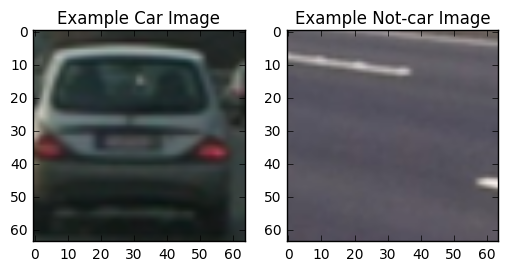

In [191]:
# Read in car images (manual split train & test data by taking bottom 20% images from each folder as testing data)
cars_train = []
cars_test = []
car_paths = ['KITTI_extracted', 'GTI_Far', 'GTI_Left', 'GTI_MiddleClose',  'GTI_Right']

for path in car_paths:
    car_files = glob.glob('train_data/vehicles/' + path + '/*.png')
    split = int(len(car_files)*0.8)
    for i in range(0, len(car_files)):
        img = mpimg.imread(car_files[i])
        if i <= split:
            cars_train.append(img)
        else:
            cars_test.append(img)
cars_train = np.asarray(cars_train)
cars_test = np.asarray(cars_test)
print('Car training dataset size: ', cars_train.shape)
print('Car testing dataset size: ', cars_test.shape)

# Read in non car images (manual split train & test data by taking bottom 20% images from each folder as testing data)
notcars_train = []
notcars_test = []
notcar_paths_train = ['Extras', 'GTI']

for path in notcar_paths_train:
    notcar_files = glob.glob('train_data/non-vehicles/' + path + '/*.png')
    split = int(len(notcar_files)*0.8)
    for i in range(0, len(notcar_files)):
        img = mpimg.imread(notcar_files[i])
        if i <= split:
            notcars_train.append(img)
        else:
            notcars_test.append(img)
notcars_train = np.asarray(notcars_train)
notcars_test = np.asarray(notcars_test)
print('Not car training dataset size', notcars_train.shape)
print('Not car testing dataset size', notcars_test.shape)
       
# Show random selected car and non-car images
car_ind = np.random.randint(0, len(cars_train))
notcar_ind = np.random.randint(0, len(notcars_train))
car_image = cars_train[car_ind]
notcar_image = notcars_train[notcar_ind]
print('Car image data type: ', car_image.dtype)
print('Non car image data type: ', notcar_image.dtype)

fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

#### HOG feature extraction on car and non car sample images

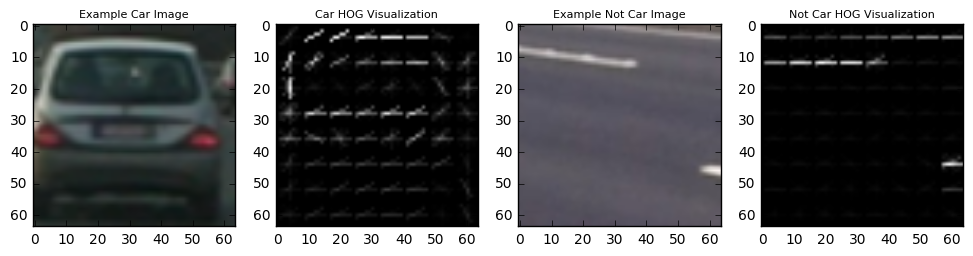

In [192]:
# HOG parameters
orient = 8
pix_per_cell = 8
cell_per_block = 2

# Convert image to gray
car_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
notcar_gray = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)

# Call hog function with vis=True to see an image output
car_feat, car_hog = get_hog_features(car_gray, orient, 
                                     pix_per_cell, cell_per_block, 
                                     vis=True, feature_vec=False)
notcar_feat, notcar_hog = get_hog_features(notcar_gray, orient, 
                                           pix_per_cell, cell_per_block, 
                                           vis=True, feature_vec=False)
# Plot the examples
fig, axis = plt.subplots(1, 4, figsize=(12, 12))
axis[0].imshow(car_image)
axis[0].set_title('Example Car Image', fontsize=8)
axis[1].imshow(car_hog, cmap='gray')
axis[1].set_title('Car HOG Visualization', fontsize=8)
axis[2].imshow(notcar_image)
axis[2].set_title('Example Not Car Image', fontsize=8)
axis[3].imshow(notcar_hog, cmap='gray')
axis[3].set_title('Not Car HOG Visualization', fontsize=8)

#### Tune feacture extraction parameters with classfier

In [193]:
##################### Feature extraction parameters

#Color space, can be RGB, HSV, LUV, HLS, YUV, YCrCb
color_space = 'YCrCb'
# HOG orientations
orient = 16
# HOG pixels per cell
pix_per_cell = 8
# HOG cells per block
cell_per_block = 2 
# HOG color channel, can be 0, 1, 2, or "ALL"
hog_channel = "ALL"
# Spatial binning dimensions
spatial_size = (16, 16) 
# Number of histogram bins
hist_bins = 32 
# Spatial features on or off
spatial_feat = True
# Histogram features on or off
hist_feat = True
# HOG features on or off
hog_feat = True 

####################### Extract car & non car features

car_features_train = []
for img in cars_train:
    features = single_img_features(img, color_space=color_space, 
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    car_features_train.append(features)

car_features_test = []
for img in cars_test:
    features = single_img_features(img, color_space=color_space, 
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    car_features_test.append(features)

notcar_features_train = []
for img in notcars_train:
    features = single_img_features(img, color_space=color_space, 
                                   spatial_size=spatial_size, hist_bins=hist_bins, 
                                   orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features_train.append(features)
    
notcar_features_test = []
for img in notcars_test:
    features = single_img_features(img, color_space=color_space, 
                                   spatial_size=spatial_size, hist_bins=hist_bins, 
                                   orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features_test.append(features)

###################### Stack & Normarlize features 

# Stack car features & non car features
X = np.vstack((car_features_train, notcar_features_train, car_features_test, notcar_features_test))                    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
X_train = X_scaler.transform(np.vstack((car_features_train, notcar_features_train)))
X_test = X_scaler.transform(np.vstack((car_features_test, notcar_features_test)))
# Define the labels vector
y_train = np.hstack((np.ones(len(car_features_train)), np.zeros(len(notcar_features_train))))
y_test= np.hstack((np.ones(len(car_features_test)), np.zeros(len(notcar_features_test))))

In [212]:
###################### Train classfier model

# Test RandomForest classifier
#parameters = {'n_estimators':[100, 300, 500], 'max_depth':[5, 10, 15], 
#              'min_samples_leaf': [2, 5, 10], 'max_features': [3, 10, 30]}
#rf = RandomForestClassifier()
#clf = GridSearchCV(rf, parameters)

# Test Linear SVM
parameters = {'C':[0.1, 1, 10], 'loss': ['hinge', 'squared_hinge']}
svc = LinearSVC()
clf = GridSearchCV(svc, parameters)

# Check the training time
t=time.time()

# Fit the model
print('Start training model...')
clf.fit(X_train, y_train)
print('Time for training model = ', round(time.time()- t, 2), 'seconds')

# Check the score of the classifer
print('Test accuracy of model = ', round(clf.score(X_test, y_test), 4))

# Print best parameters
print(clf.best_params_)

Start training model...
Time for training model =  160.68 seconds
Test accuracy of model =  0.9853
{'loss': 'hinge', 'C': 0.1}


### 2. Sliding Window Search

In [208]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, clf, X_scaler, color_space,
              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Create an empty list to receive positive detection windows
    on_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                on_windows.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                
    return on_windows

In [209]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

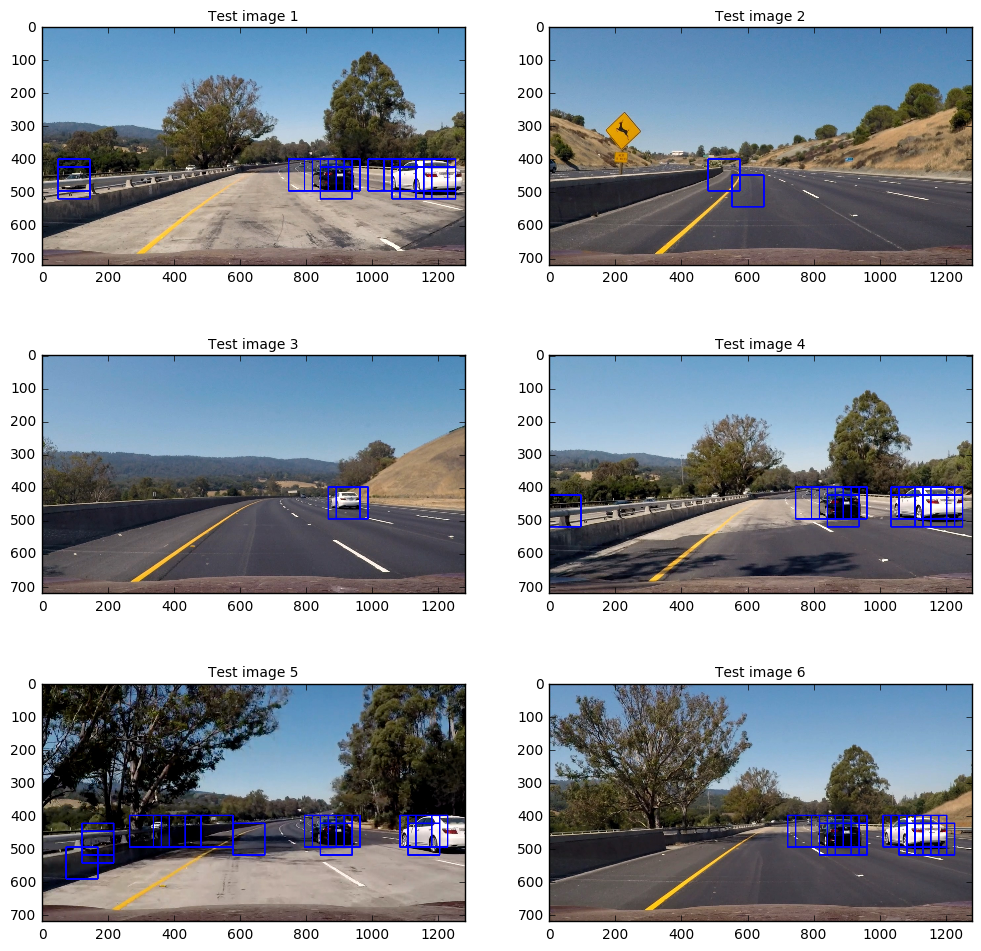

In [213]:
i = 0
fig, axis = plt.subplots(3, 2, figsize=(12, 12))

# Get list of test images
test_images = glob.glob('test_images/test*.jpg')

# Loop to test on each image
for file in test_images:
    
    # Read image
    test_img = mpimg.imread(file)
    draw_img = np.copy(test_img)
    
    # Find cars
    bbox_list = find_cars(img=test_img, ystart=400, ystop=650, scale=1.5, 
                          clf=clf, X_scaler=X_scaler, color_space=color_space,
                          orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                          spatial_size=spatial_size, hist_bins=hist_bins)
    
    # Draw detected boxes to orignial image
    window_img = draw_boxes(draw_img, bbox_list, color=(0, 0, 255), thick=3)
    
    # Plot image
    axis[int(i/2), i%2].imshow(window_img)
    axis[int(i/2), i%2].set_title('Test image {}'.format(i+1), fontsize=10)
    
    # Increment the counter
    i += 1

# Save figure
fig.savefig('sliding_windows.png')

### 3. Video Pipeline

In [214]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [215]:
def draw_labeled_bboxes(img, labels):
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 3)
    # Return the image
    return img

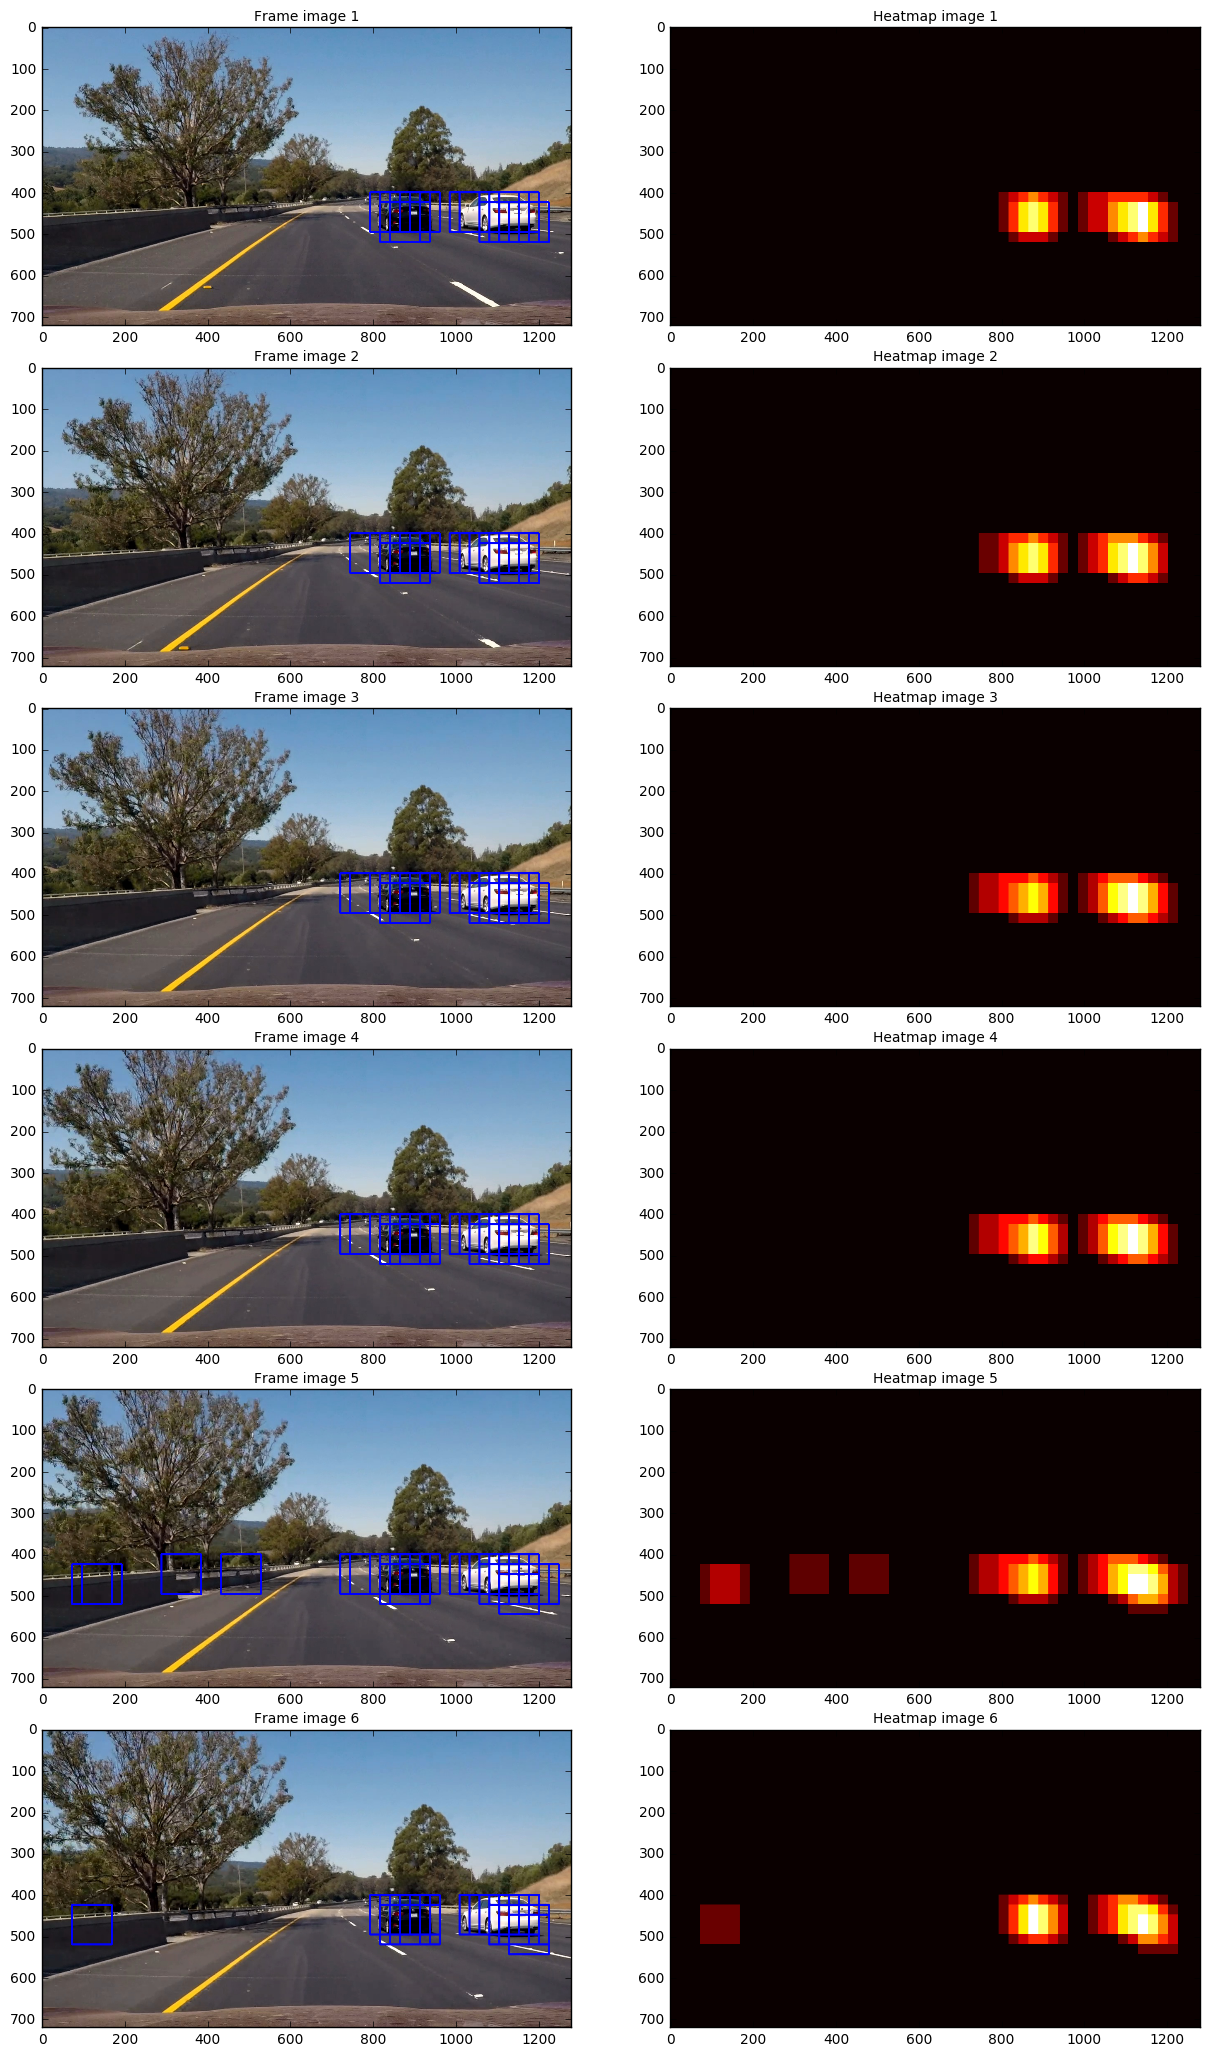

In [219]:
# Get list of test images
test_images = glob.glob('test_images/frame*.jpg')

# Set the plot figure & axis
fig, axis = plt.subplots(len(test_images), 2, figsize=(12, 20))
fig.tight_layout()

# Heatmap over multiple frames
heatmap_overframes = np.zeros(mpimg.imread(test_images[0]).shape[:2])

# Loop to test on each image
for i in range(0, len(test_images)):
    
    # Read and pre-treat image
    test_img = mpimg.imread(test_images[i])
    draw_img = np.copy(test_img)
    
    # Find cars
    bbox_list = find_cars(img=test_img, ystart=400, ystop=656, scale=1.5, 
                          clf=clf, X_scaler=X_scaler, color_space=color_space,
                          orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                          spatial_size=spatial_size, hist_bins=hist_bins)
    
    # Draw detected boxes to orignial image
    window_img = draw_boxes(draw_img, bbox_list, color=(0, 0, 255), thick=4)
    
    # Plot image
    axis[i, 0].imshow(window_img)
    axis[i, 0].set_title('Frame image {}'.format(i+1), fontsize=10)
    
    # Create an empty heatmap
    heatmap = np.zeros(test_img.shape[:2])
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Add new heatmap to previously summed heatmap
    heatmap_overframes = heatmap_overframes + heatmap
    
    # Plot heatmap
    axis[i, 1].imshow(heatmap, cmap='hot')
    axis[i, 1].set_title('Heatmap image {}'.format(i+1), fontsize=10)
    
    # Adjust the plot figure
    plt.subplots_adjust(left=0., right=1.0, top=1.0, bottom=0.)
    
# Save figure
fig.savefig('bboxes_and_heat.png')

2 cars found


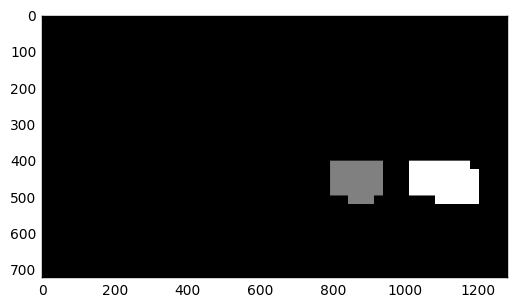

In [220]:
threshold = 10
# Threshold the heatmap by zero out pixels below the threshold
heatmap_overframes[heatmap_overframes <= threshold] = 0
# Find nb of vehicles and their positions
labels = label(heatmap_overframes)
# Show result
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
# Save the labels image
mpimg.imsave("labels_map.png", labels[0], cmap='gray')

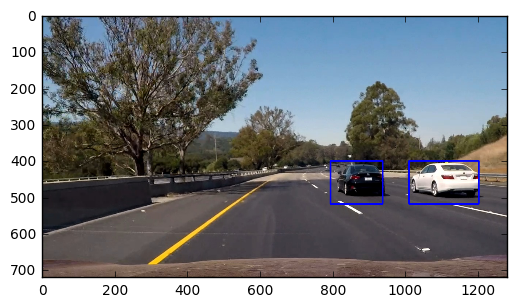

In [221]:
# Read in the last image above
image = mpimg.imread('test_images/frame5.jpg')
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(draw_img)
# Save the image
mpimg.imsave("output_bboxes.png", draw_img)

In [222]:
class VideoHeatmap():
    
    nb_frames = 0
    threshold = 0
    heatmap_list = []
    
    def __init__(self, nb_frames, threshold):
        self.nb_frames = nb_frames
        self.threshold = threshold
        
    def add_heatmap(self, heatmap):
        if len(self.heatmap_list) > self.nb_frames:
            self.heatmap_list = self.heatmap_list[1:]
        self.heatmap_list.append(heatmap)
        
    def get_heatmap_over_frames(self):
        heatmap_overframes = self.heatmap_list[0]
        for hmap in self.heatmap_list[1:]:
            heatmap_overframes = heatmap_overframes + hmap
        return heatmap_overframes
    
    def threshold_heatmap(self, heatmap):
        heatmap[heatmap <= self.threshold] = 0
        return heatmap

In [223]:
def process_image(image):
    
    # Find cars
    bbox_list = find_cars(img=image, ystart=400, ystop=650, scale=1.5, 
                          clf=clf, X_scaler=X_scaler, color_space=color_space,
                          orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                          spatial_size=spatial_size, hist_bins=hist_bins)
    bbox_list += find_cars(img=image, ystart=450, ystop=700, scale=2.5, 
                           clf=clf, X_scaler=X_scaler, color_space=color_space,
                           orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                           spatial_size=spatial_size, hist_bins=hist_bins)
    
    # Create an empty heatmap
    heatmap = np.zeros(image.shape[:2])
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    # Compute heatmap summed over multiple frames
    video_heatmap.add_heatmap(heatmap)
    heatmap_overframes = video_heatmap.get_heatmap_over_frames()
    
    # Threshold the heatmap by zero out pixels below the threshold
    heatmap_overframes = video_heatmap.threshold_heatmap(heatmap_overframes)

    # Find nb of vehicles and their positions
    labels = label(heatmap_overframes)
    
    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    # Return drawed image
    return draw_img

In [234]:
video_heatmap = VideoHeatmap(nb_frames=6, threshold=7)
project_output = 'project.mp4'
clip_project = VideoFileClip("project_video.mp4")
project_clip = clip_project.fl_image(process_image)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project.mp4
[MoviePy] Writing video project.mp4


100%|█████████▉| 1260/1261 [10:21<00:01,  1.04s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project.mp4 

CPU times: user 18min 41s, sys: 55.3 s, total: 19min 36s
Wall time: 10min 24s


In [236]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))